 # Linear Classifiers, Incomplete Labels, and Imbalanced Datasets

 This notebook is based on Problem Set 2 of course XCS229 from Stanford AI program. It includes:
 1. **Linear Classifiers** (Logistic Regression and Gaussian Discriminant Analysis)
 2. **Handling Incomplete**, Positive-Only Labels
 3. Learning from **Imbalanced Datasets**

 Each section includes brief explanations and code implementations that can be run independently.

 ---------------------------------------------------------------
 Section 1: Linear Classifiers (Logistic Regression and GDA)
 ---------------------------------------------------------------

 In this section, we implement logistic regression and Gaussian discriminant analysis (GDA) classifiers from scratch.
 We apply these classifiers to datasets and visualize their decision boundaries to understand their performance.

In [74]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [75]:
# Utility functions for data loading and plotting
def load_dataset(file_path, label_col='y', add_intercept=False):
    """
    Load the dataset from a CSV file.

    Args:
        file_path: str
            The path to the CSV file.
        label_col: str
            The name of the label column ('y' or 't').
        add_intercept: bool
            Whether to add an intercept term to the features.

    Returns:
        X: np.ndarray
            The input features.
        y: np.ndarray
            The target values.
    """
    data = pd.read_csv(file_path)
    X = data[['x_1', 'x_2']].values
    y = data[label_col].values.flatten()
    if add_intercept:
        intercept = np.ones((X.shape[0], 1))
        X = np.hstack((intercept, X))
    return X, y

In [76]:
X_train, y_train = load_dataset("data/ds1_train.csv", label_col='y')

X_train.shape, y_train.shape

((800, 2), (800,))

In [86]:
def plot_decision_boundary(x, y, theta=None, threshold=0.5, title=""):
    plt.figure()
    # Determine if intercept term is present
    if x.shape[1] == 3:
        feature1_index = 1
        feature2_index = 2
    else:
        feature1_index = 0
        feature2_index = 1
    # Scatter plot for each class
    plt.scatter(x[y == 0, feature1_index], x[y == 0, feature2_index], label='Class 0')
    plt.scatter(x[y == 1, feature1_index], x[y == 1, feature2_index], label='Class 1')
    if theta is not None:
        # Compute c based on the threshold
        c = -np.log((1 - threshold) / threshold)
        x_boundary = np.array([min(x[:, feature1_index]), max(x[:, feature1_index])])
        y_boundary = -(theta[0] + theta[feature1_index] * x_boundary - c) / theta[feature2_index]
        plt.plot(x_boundary, y_boundary, 'k--', label='Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    
    y_min, y_max = x[:, feature2_index].min(), x[:, feature2_index].max()
    x_min, x_max = x[:, feature1_index].min(), x[:, feature1_index].max()
    
    # Set axis limits
    plt.xlim(x_min - 1, x_max + 1)
    plt.ylim(y_min - 1, y_max + 1)
    
    plt.show()

def plot_posonly(x, y, theta=None, threshold=0.5, correction=1.0, title=""):
    """
    Plot dataset and fitted logistic regression parameters for positive-only labels.

    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        threshold: Decision threshold (default 0.5).
        correction: Correction factor to apply, if any.
        title: Title of the plot.
    """
    plt.figure()
    # Determine if intercept term is present
    if x.shape[1] == 3:
        feature1_index = 1
        feature2_index = 2
    else:
        feature1_index = 0
        feature2_index = 1

    # Scatter plot for each class
    plt.scatter(x[y == 0, feature1_index], x[y == 0, feature2_index], label='Class 0')
    plt.scatter(x[y == 1, feature1_index], x[y == 1, feature2_index], label='Class 1')

    if theta is not None:
        # Compute c based on the threshold and correction factor
        adjusted_threshold = threshold * correction
        c = -np.log((1 - adjusted_threshold) / adjusted_threshold)
        # Extend the range of x1 values
        x_min, x_max = x[:, feature1_index].min() - 1, x[:, feature1_index].max() + 1
        x1_vals = np.linspace(x_min, x_max, 200)
        # Compute corresponding x2 values
        theta_feature1 = theta[feature1_index]
        theta_feature2 = theta[feature2_index]
        if abs(theta_feature2) < 1e-6:
            # Avoid division by zero
            x2_vals = np.full_like(x1_vals, -theta[0] / theta_feature2)
        else:
            x2_vals = -(theta[0] + theta_feature1 * x1_vals - c) / theta_feature2
        # Filter out any NaN or infinite values
        valid_idx = np.isfinite(x2_vals)
        x1_vals = x1_vals[valid_idx]
        x2_vals = x2_vals[valid_idx]
        plt.plot(x1_vals, x2_vals, 'k--', label='Decision Boundary')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()

    y_min, y_max = x[:, feature2_index].min(), x[:, feature2_index].max()
    x_min, x_max = x[:, feature1_index].min(), x[:, feature1_index].max()

    # Set axis limits
    plt.xlim(x_min - 1, x_max + 1)
    plt.ylim(y_min - 1, y_max + 1)

    plt.show()



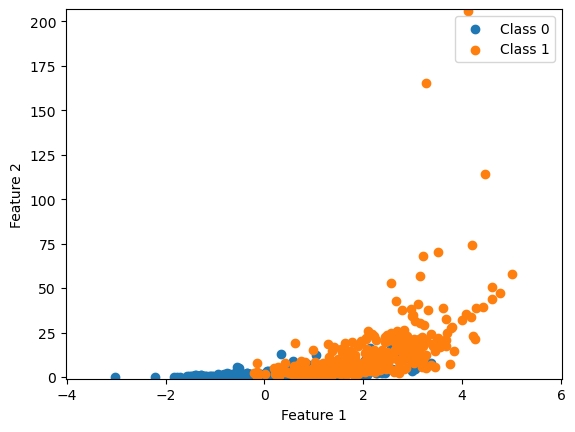

In [78]:
# Let's plot without providing theta yet
plot_decision_boundary(X_train, y_train)


## Logistic Regression Classifier
 -----------------------------

  ### Logistic Regression

 Logistic Regression is a statistical model used for binary classification tasks. It models the probability that a given input point belongs to a particular class.

 The model assumes the following form:

 $$
 h_\theta(x) = g(\theta^T x) = \frac{1}{1 + e^{-\theta^T x}}
 $$

 where:
 - $h_\theta(x)$ is the predicted probability that $y=1$ given input $x$.
 - $g(z)$ is the sigmoid function, which maps any real number into the range $(0, 1)$.
 - $\theta$ is the parameter vector to be learned.

 The goal is to find the parameters $\theta$ that minimize the cost function $J(\theta)$.

  ### Cost Function

 The cost function for Logistic Regression is defined as:

 $$
 J(\theta) = -\frac{1}{n} \sum_{i=1}^n \left[ y^{(i)} \log h_\theta(x^{(i)}) + (1 - y^{(i)}) \log \left(1 - h_\theta(x^{(i)})\right) \right]
 $$

 where:
 - $n$ is the number of training examples.
 - $y^{(i)}$ is the true label for the $i$-th example.

 This cost function is derived from the likelihood function, assuming that the outputs are Bernoulli distributed.

  ### Newton's Method for Optimization

 Newton's Method is an optimization algorithm that uses both the first and second derivatives of the cost function to find the parameters that minimize it.

  ### Gradient and Hessian

 - The **gradient** of the cost function is a vector of partial derivatives with respect to each parameter $\theta_j$:

   $$
   \nabla J(\theta) = \frac{\partial J(\theta)}{\partial \theta} = \frac{1}{n} X^T (h - y)
   $$

   where:
   - $X$ is the design matrix of shape $(n, d)$.
   - $h$ is the vector of predicted probabilities for all training examples.
   - $y$ is the vector of true labels.

 - The **Hessian** matrix is a square matrix of second-order partial derivatives:

   $$
   H = \nabla^2 J(\theta) = \frac{1}{n} X^T W X
   $$

   where:
   - $W$ is a diagonal matrix where $W_{ii} = h_i (1 - h_i)$.

  ### Parameter Update Rule

 Newton's Method updates the parameters using the following rule:

 $$
 \theta_{\text{new}} = \theta_{\text{old}} - H^{-1} \nabla J(\theta)
 $$

 This involves computing the inverse of the Hessian matrix, which can be computationally expensive for large datasets.


In [79]:
class LogisticRegression:
    """
    Logistic Regression Classifier using Newton's Method.
    """

    def __init__(self, eps=1e-5, max_iter=100000, verbose=False):
        self.theta = None
        self.eps = eps
        self.max_iter = max_iter
        self.verbose = verbose

    def fit(self, x, y):
        """
        Fit the model to the data using Newton's Method.
        """
        n_samples, n_features = x.shape
        self.theta = np.zeros(n_features)

        for i in range(self.max_iter):
            z = x @ self.theta
            h = 1 / (1 + np.exp(-z))
            gradient = x.T @ (h - y) / n_samples
            H = (x.T * (h * (1 - h))) @ x / n_samples
            delta = np.linalg.solve(H, gradient)
            self.theta -= delta
            if np.linalg.norm(delta, 1) < self.eps:
                if self.verbose:
                    print(f'Converged at iteration {i}')
                break

    def predict_proba(self, x):
        """
        Predict probabilities for the input data.
        """
        return 1 / (1 + np.exp(-x @ self.theta))

    def predict(self, x):
        """
        Predict class labels for the input data.
        """
        return (self.predict_proba(x) >= 0.5).astype(int)


## Gaussian Discriminant Analysis
 -----------------------------

Gaussian Discriminant Analysis is a generative learning algorithm used for classification. It models the joint probability distribution of the features and the labels, and then uses Bayes' theorem to compute the posterior probabilities.

 **Key Characteristics:**

 - **Generative Model:** It models how the data is generated by estimating the probability distributions.
 - **Assumption:** The conditional distribution of the features given the class label is Gaussian (normal distribution).
 - **Shared Covariance Matrix:** In Linear Discriminant Analysis (LDA), the covariance matrices for each class are assumed to be the same.

 We are given a training set $\{ (x^{(i)}, y^{(i)}) \}_{i=1}^n$ where:

 - $x^{(i)} \in \mathbb{R}^d$ is the feature vector.
 - $y^{(i)} \in \{0, 1\}$ is the class label.

 **Modeling the Distributions:**

 - **Prior Probability:**

   $$
   \phi = p(y = 1)
   $$

 - **Class-Conditional Densities:**

   $$
   p(x | y = 0) = \mathcal{N}(x; \mu_0, \Sigma) \\
   p(x | y = 1) = \mathcal{N}(x; \mu_1, \Sigma)
   $$

   where $\mathcal{N}(x; \mu, \Sigma)$ denotes the multivariate normal distribution with mean $\mu$ and covariance $\Sigma$.

  ### Parameter Estimation

 We estimate the parameters $\phi$, $\mu_0$, $\mu_1$, and $\Sigma$ using Maximum Likelihood Estimation (MLE).

 - **Estimate of $\phi$:**

   $$
   \phi = \frac{1}{n} \sum_{i=1}^n 1\{ y^{(i)} = 1 \}
   $$

 - **Estimates of Means:**

   $$
   \mu_0 = \frac{\sum_{i=1}^n 1\{ y^{(i)} = 0 \} x^{(i)}}{\sum_{i=1}^n 1\{ y^{(i)} = 0 \}} \\
   \mu_1 = \frac{\sum_{i=1}^n 1\{ y^{(i)} = 1 \} x^{(i)}}{\sum_{i=1}^n 1\{ y^{(i)} = 1 \}}
   $$

 - **Estimate of Shared Covariance Matrix $\Sigma$:**

   $$
   \Sigma = \frac{1}{n} \sum_{i=1}^n \left( x^{(i)} - \mu_{y^{(i)}} \right) \left( x^{(i)} - \mu_{y^{(i)}} \right)^T
   $$

   Here, $\mu_{y^{(i)}}$ means $\mu_0$ if $y^{(i)} = 0$ and $\mu_1$ if $y^{(i)} = 1$.

  ### Making Predictions

 **Posterior Probability:**

 Using Bayes' theorem, the posterior probability that $y = 1$ given $x$ is:

 $$
 p(y = 1 | x) = \frac{p(x | y = 1) p(y = 1)}{p(x)}
 $$

 **Decision Rule:**

 We predict $y = 1$ if $p(y = 1 | x) \geq 0.5$, otherwise $y = 0$.

  ### Linear Decision Boundary

 Under the assumption of shared covariance matrices, the logarithm of the likelihood ratio is a linear function of $x$:

 $$
 \log \left( \frac{p(x | y = 1)}{p(x | y = 0)} \right) = \theta_0 + \theta^T x
 $$

 where:

 - $\theta = \Sigma^{-1} (\mu_1 - \mu_0)$
 - $\theta_0 = -\frac{1}{2} (\mu_1^T \Sigma^{-1} \mu_1 - \mu_0^T \Sigma^{-1} \mu_0) + \log\left( \frac{\phi}{1 - \phi} \right)$

 Therefore, GDA results in a linear decision boundary.

In [80]:
class GDA:
    """
    Gaussian Discriminant Analysis Classifier.
    """

    def __init__(self):
        self.theta = None
        self.phi = None
        self.mu_0 = None
        self.mu_1 = None
        self.sigma = None

    def fit(self, x, y):
        """
        Fit the model to the data.
        """
        n_samples, n_features = x.shape
        self.phi = np.mean(y)
        self.mu_0 = np.mean(x[y == 0], axis=0)
        self.mu_1 = np.mean(x[y == 1], axis=0)
        self.sigma = np.cov(x[y == 0].T, bias=True) * (1 - self.phi) + np.cov(x[y == 1].T, bias=True) * self.phi
        sigma_inv = np.linalg.inv(self.sigma)
        theta = sigma_inv @ (self.mu_1 - self.mu_0)
        theta_0 = (np.log(self.phi / (1 - self.phi))
                   - 0.5 * self.mu_1.T @ sigma_inv @ self.mu_1
                   + 0.5 * self.mu_0.T @ sigma_inv @ self.mu_0)
        self.theta = np.hstack([theta_0, theta])

    def predict_proba(self, x):
        """
        Predict probabilities for the input data.
        """
        return 1 / (1 + np.exp(-x @ self.theta))

    def predict(self, x):
        """
        Predict class labels for the input data.
        """
        return (self.predict_proba(x) >= 0.5).astype(int)

## Applying Logistic Regression and GDA
 ---------------------------------------------------------------

### Dataset 1

Logistic Regression on Dataset 1
Converged at iteration 7


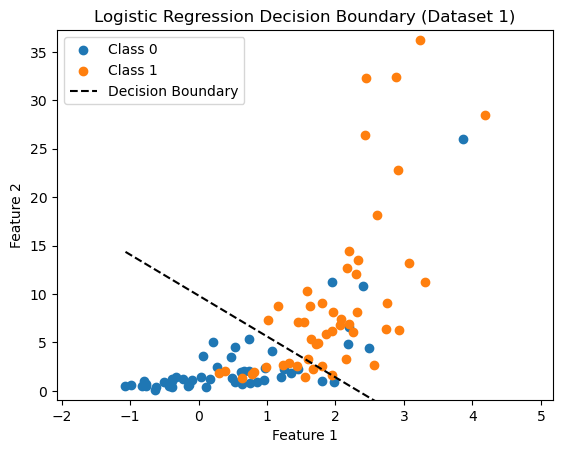

GDA on Dataset 1


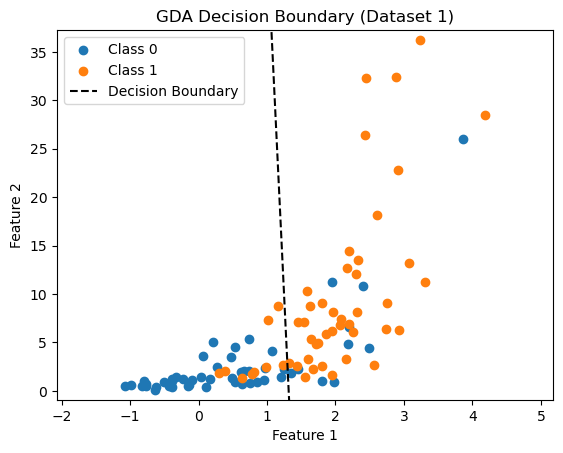

In [81]:
# Load Dataset 1
X_train_ds1, y_train_ds1 = load_dataset('data/ds1_train.csv', add_intercept=True)
X_valid_ds1, y_valid_ds1 = load_dataset('data/ds1_valid.csv', add_intercept=True)

# Logistic Regression on Dataset 1
print("Logistic Regression on Dataset 1")
log_reg_ds1 = LogisticRegression(verbose=True)
log_reg_ds1.fit(X_train_ds1, y_train_ds1)
plot_decision_boundary(X_valid_ds1, y_valid_ds1, log_reg_ds1.theta, title="Logistic Regression Decision Boundary (Dataset 1)")

# Gaussian Discriminant Analysis on Dataset 1
print("GDA on Dataset 1")
# For GDA, we do not include the intercept term in X
X_train_ds1_no_intercept, y_train_ds1 = load_dataset('data/ds1_train.csv', add_intercept=False)
X_valid_ds1_no_intercept, y_valid_ds1 = load_dataset('data/ds1_valid.csv', add_intercept=False)
gda_ds1 = GDA()
gda_ds1.fit(X_train_ds1_no_intercept, y_train_ds1)
plot_decision_boundary(X_valid_ds1, y_valid_ds1, gda_ds1.theta, title="GDA Decision Boundary (Dataset 1)")


### Dataset 2

Logistic Regression on Dataset 2
Converged at iteration 5


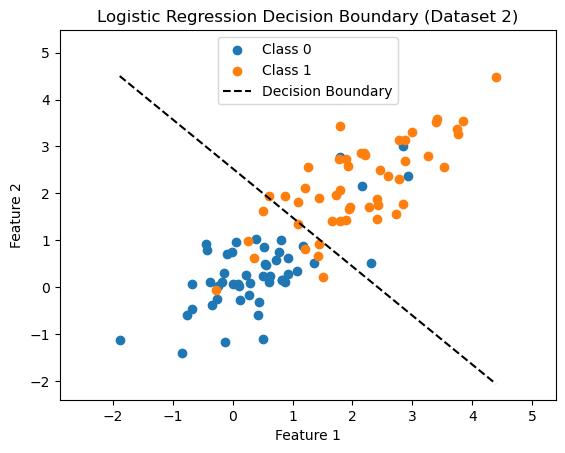

GDA on Dataset 2


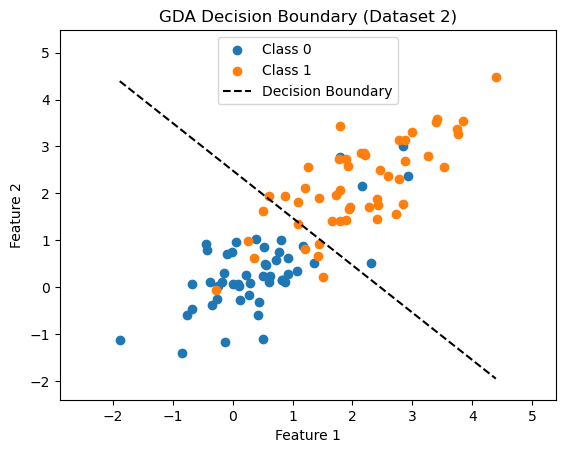

In [82]:
# Load Dataset 2
X_train_ds2, y_train_ds2 = load_dataset('data/ds2_train.csv', add_intercept=True)
X_valid_ds2, y_valid_ds2 = load_dataset('data/ds2_valid.csv', add_intercept=True)

# Logistic Regression on Dataset 2
print("Logistic Regression on Dataset 2")
log_reg_ds2 = LogisticRegression(verbose=True)
log_reg_ds2.fit(X_train_ds2, y_train_ds2)
plot_decision_boundary(X_valid_ds2, y_valid_ds2, log_reg_ds2.theta, title="Logistic Regression Decision Boundary (Dataset 2)")

# Gaussian Discriminant Analysis on Dataset 2
print("GDA on Dataset 2")
# For GDA, we do not include the intercept term in X
X_train_ds2_no_intercept, y_train_ds2 = load_dataset('data/ds2_train.csv', add_intercept=False)
X_valid_ds2_no_intercept, y_valid_ds2 = load_dataset('data/ds2_valid.csv', add_intercept=False)
gda_ds2 = GDA()
gda_ds2.fit(X_train_ds2_no_intercept, y_train_ds2)
plot_decision_boundary(X_valid_ds2, y_valid_ds2, gda_ds2.theta, title="GDA Decision Boundary (Dataset 2)")


-------------------------------------------
Section 2: Incomplete, Positive-Only Labels
-------------------------------------------

In this section, we consider training binary classifiers in situations where we do not have full access to the labels. In particular, we consider a scenario where we have labels only for a subset of the positive examples. All the negative examples and the rest of the positive examples are unlabeled.

We formalize the scenario as follows. Let $\{(x^{(i)}, t^{(i)})\}_{i=1}^{n}$ be a standard dataset of i.i.d distributed examples. Here $x^{(i)}$’s are the inputs/features and $t^{(i)}$ are the true labels. Now consider the situation where $t^{(i)}$’s are not observed by us. Instead, we only observe the labels $y^{(i)}$’s that are generated by:

- For $t^{(i)}=1$ (positive examples):
    - $p(y^{(i)}=1 | t^{(i)}=1, x^{(i)}) = \alpha$
    - $p(y^{(i)}=0 | t^{(i)}=1, x^{(i)}) = 1 - \alpha$
- For $t^{(i)}=0$ (negative examples):
    - $p(y^{(i)}=1 | t^{(i)}=0, x^{(i)}) = 0$
    - $p(y^{(i)}=0 | t^{(i)}=0, x^{(i)}) = 1$

Our goal is to construct a binary classifier $h$ of the true label $t$, with only access to the partial label $y$. In other words, we want to construct $h$ such that $h(x^{(i)}) \approx p(t^{(i)} = 1 | x^{(i)})$ as closely as possible, using only $x$ and $y$.

First, we consider the hypothetical (and uninteresting) case where we have access to the true $t$-labels for training.

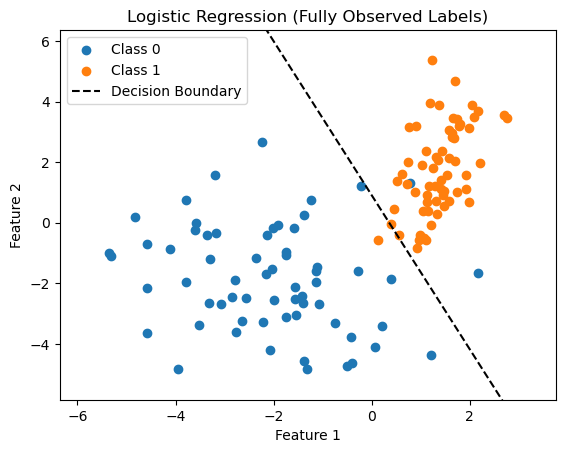

In [83]:
# Load the training data with t-labels
X_train_t, t_train = load_dataset('data/train_incomplete.csv', label_col='t', add_intercept=True)

# Implement Logistic Regression and train on t-labels
log_reg_full = LogisticRegression()
log_reg_full.fit(X_train_t, t_train)

# Load test data
X_test_t, t_test = load_dataset('data/test_incomplete.csv', label_col='t', add_intercept=True)

# Predict on test data
predictions_full = log_reg_full.predict(X_test_t)

# Plot decision boundary
plot_decision_boundary(X_test_t, t_test, log_reg_full.theta, title="Logistic Regression (Fully Observed Labels)")

Next, we consider the case where the $t$-labels are unavailable, so we only have access to the $y$-labels at training time.

We re-train the classifier using $x$ and $y$.

Converged at iteration 7
Theta after training on partial labels: [-2.91607454  0.78596651  0.09282768]


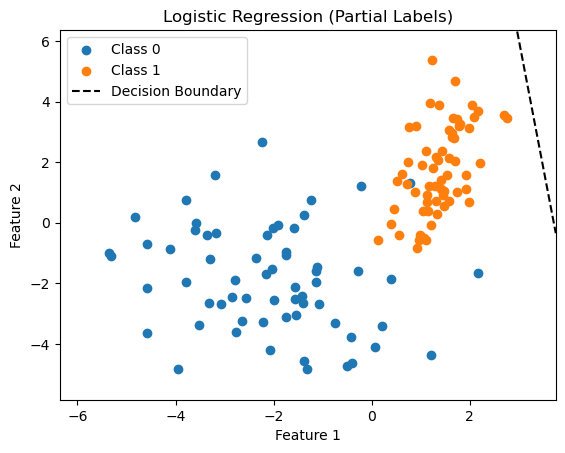

In [87]:
# Load training data with y-labels
X_train_y, y_train = load_dataset('data/train_incomplete.csv', label_col='y', add_intercept=True)

# Train logistic regression on y-labels
log_reg_partial = LogisticRegression(verbose=True)
log_reg_partial.fit(X_train_y, y_train)

print("Theta after training on partial labels:", log_reg_partial.theta)

# Predict on test data (we'll compare with true t-labels)
predictions_partial = log_reg_partial.predict(X_test_t)

# Plot decision boundary on test data
plot_posonly(X_test_t, t_test, log_reg_partial.theta, title="Logistic Regression (Partial Labels)")

We now estimate $\alpha$ using the validation set.

We use the following formula:

$$
\alpha \approx \frac{1}{|V^+|} \sum_{x \in V^+} h(x)
$$

where $V^+$ is the set of labeled (positive) examples in the validation set.

Estimated alpha: 0.17174527144749677


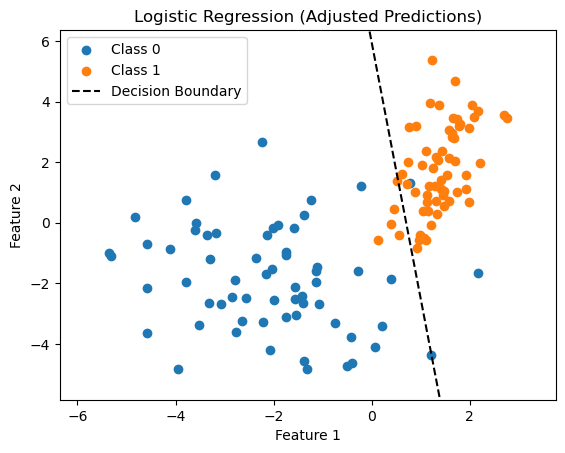

In [89]:
# Load validation data
X_val, y_val = load_dataset('data/valid_incomplete.csv', label_col='y', add_intercept=True)
X_val_t, t_val = load_dataset('data/valid_incomplete.csv', label_col='t', add_intercept=True)

# Compute h(x) for validation data
h_x_val = log_reg_partial.predict_proba(X_val)

# Extract labeled examples (y=1)
V_plus_indices = np.where(y_val == 1)[0]
h_x_val_plus = h_x_val[V_plus_indices]

# Estimate alpha
alpha_est = np.mean(h_x_val_plus)

print(f"Estimated alpha: {alpha_est}")

# Adjust predictions on test data
adjusted_probs = log_reg_partial.predict_proba(X_test_t) / alpha_est
adjusted_probs = np.clip(adjusted_probs, 0, 1)  # Ensure probabilities are between 0 and 1
adjusted_predictions = (adjusted_probs >= 0.5).astype(int)

# Plot adjusted decision boundary
plot_posonly(X_test_t, t_test, theta=log_reg_partial.theta, correction=alpha_est, title="Logistic Regression (Adjusted Predictions)")